# Installation and Imports


In [1]:
!pip install cuquantum-python cupy-cuda12x tensornetwork quimb

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.5/937.5 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
!pip install cotengra kahypar optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 26.3 MB/s eta 0:00:00


In [1]:
import cupy as cp
import numpy as np
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt

import time
from pynvml import *
import gc
from tqdm import tqdm

from scipy.fft import fft, fftfreq

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from collections.abc import Iterable

np.random.seed(42)
cp.random.seed(42)

ModuleNotFoundError: No module named 'quimb'

#

# Warmup with MPS:

Initializing MPS on GPU...


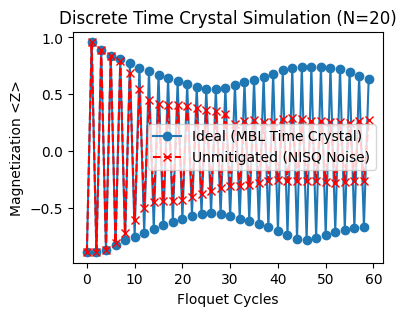

In [4]:
# configuration
N = 20
CYCLES = 60
BOND_DIM = 64
NOISE_PROB = 0.02

# parameters
J_coupling = 0.25
epsilon = 0.15

# gate generation(GPU)
def get_Rx_matrix(theta):
    val = theta / 2.0
    return cp.array([[cp.cos(val), -1j * cp.sin(val)],
                     [-1j * cp.sin(val), cp.cos(val)]], dtype=complex)

def get_Rzz_matrix(theta):
    val = theta / 2.0
    e_minus = cp.exp(-1j * val)
    e_plus = cp.exp(1j * val)
    return cp.diag(cp.array([e_minus, e_plus, e_plus, e_minus], dtype=complex))

def apply_floquet_layer(mps, apply_noise=False):
    angle = np.pi * (1.0 - epsilon)
    rx_gate = get_Rx_matrix(angle)

    for i in range(N):
        mps.gate_(rx_gate, i, tags={'Rx'}, contract=True)

        if apply_noise and np.random.rand() < NOISE_PROB:
            z_gate = cp.asarray(qu.pauli('Z')) # Add dephasing error
            # z_gate = 0.2*cp.asarray(qu.pauli('X')) # Add relaxation errros
            mps.gate_(z_gate, i, tags={'NOISE'}, contract=True)

    # Ising Interaction (Rzz layers)
    theta = 2 * J_coupling * np.pi
    RZZ_gate = get_Rzz_matrix(theta)

    # Use 'swap+split' to handle entanglement creation
    for i in range(N - 1):
        mps.gate_(RZZ_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)

    # Global compression
    mps.compress(max_bond=BOND_DIM, cutoff=1e-6)
    return mps

print("Initializing MPS on GPU...")

# Create state |00...0>
mps_clean = qtn.MPS_computational_state('0' * N)
mps_noisy = qtn.MPS_computational_state('0' * N)

# Move tensor data to GPU and canonicalize
mps_clean.apply_to_arrays(cp.asarray)
mps_noisy.apply_to_arrays(cp.asarray)
mps_clean.right_canonize()
mps_noisy.right_canonize()

z_magnetization_clean = []
z_magnetization_noisy = []


for t in range(CYCLES):
    # Evolve
    mps_clean = apply_floquet_layer(mps_clean, apply_noise=False)
    mps_noisy = apply_floquet_layer(mps_noisy, apply_noise=True)

    # Measure Z (Operator must be on GPU)
    Z_op = cp.asarray(qu.pauli('Z'))

    psi_prime_clean = mps_clean.gate(Z_op, N//2, contract=True)
    psi_prime_noisy = mps_noisy.gate(Z_op, N//2, contract=True)

    mz_clean = mps_clean.overlap(psi_prime_clean, optimize='auto-hq')
    mz_noisy = mps_noisy.overlap(psi_prime_noisy, optimize='auto-hq')

    # mz_clean = mps_clean.local_expectation(Z_op, N//2, max_bond=BOND_DIM, optimize='auto-hq')
    # mz_noisy = mps_noisy.local_expectation(Z_op, N//2, max_bond=BOND_DIM, optimize='auto-hq')

    z_magnetization_clean.append(mz_clean.real)
    z_magnetization_noisy.append(mz_noisy.real)

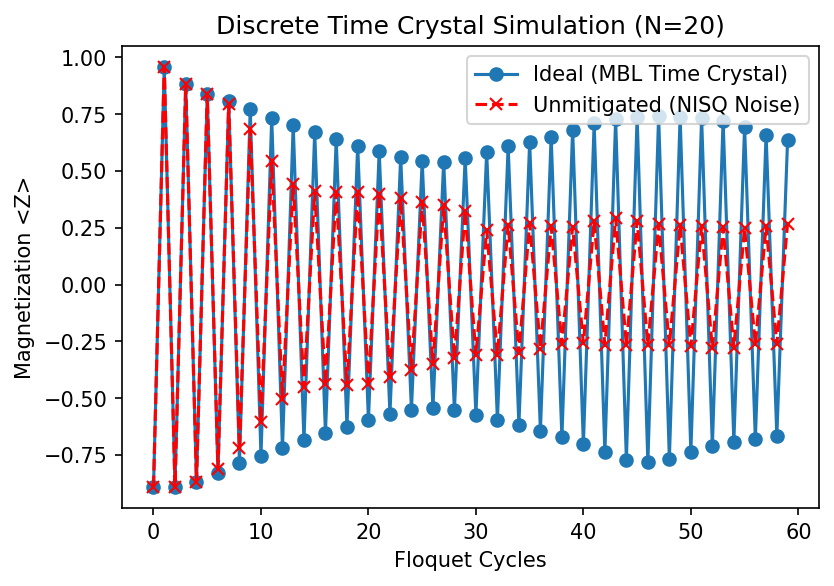

In [9]:
# Visualization
# Move data to CPU for plotting
z_clean_np = [float(x) for x in z_magnetization_clean]
z_noisy_np = [float(x) for x in z_magnetization_noisy]

plt.figure(figsize=(6, 4), dpi = 150)
plt.plot(range(CYCLES), z_clean_np, 'o-', label='Ideal (MBL Time Crystal)')
plt.plot(range(CYCLES), z_noisy_np, 'x--', color='red', label='Unmitigated (NISQ Noise)')

plt.xlabel('Floquet Cycles')
plt.ylabel('Magnetization <Z>')
plt.title(f'Discrete Time Crystal Simulation (N={N})')
plt.legend(loc = 'upper right')
# plt.grid(True)
plt.show()

# MBL-DTC + ZNE error mitigation:

In [12]:
# Configuration and Hamiltonian parameters
N = 20
CYCLES = 60
BOND_DIM = 64
BASE_NOISE_PROB = 0.0025
SHOTS = 10

J_coupling = 0.3
epsilon = 0.15

W_disorder = 3

# Gate generation (GPU)
def get_Rx_matrix(theta):
    val = theta / 2.0
    return cp.array([[cp.cos(val), -1j * cp.sin(val)],
                     [-1j * cp.sin(val), cp.cos(val)]], dtype=complex)

def get_Rzz_matrix(theta):
    val = theta / 2.0
    e_minus = cp.exp(-1j * val)
    e_plus = cp.exp(1j * val)
    return cp.diag(cp.array([e_minus, e_plus, e_plus, e_minus], dtype=complex))

h_fields = (np.random.rand(N) - 0.5) * 2 * W_disorder

def get_Rz_matrix(theta):
    val = theta / 2.0
    e_m = cp.exp(-1j * val)
    e_p = cp.exp(1j * val)
    return cp.diag(cp.array([e_m, e_p], dtype=complex))

def apply_floquet_layer(mps, noise_prob=0.0):
    # Global Kick (Rx layers)
    angle = np.pi * (1.0 - epsilon)
    rx_gate = get_Rx_matrix(angle)

    # Pre-generate noise gate (Pauli X for bit-flip noise)
    noise_gate = cp.asarray(qu.pauli('X'))

    for i in range(N):
        mps.gate_(rx_gate, i, tags={'Rx'}, contract=True)

        # Apply disorder
        rz_disorder = get_Rz_matrix(h_fields[i] * np.pi)
        mps.gate_(rz_disorder, i, tags={'Disorder'}, contract=True)

        # Apply noise if noise probability > 0
        if noise_prob > 0 and np.random.rand() < noise_prob:
            mps.gate_(noise_gate, i, tags={'NOISE'}, contract=True)

    # Ising Interaction (Rzz layers)
    theta = 2 * J_coupling * np.pi
    RZZ_gate = get_Rzz_matrix(theta)

    for i in range(N - 1):
        mps.gate_(RZZ_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)

    mps.compress(max_bond=BOND_DIM, cutoff=1e-6)
    return mps

print("Initializing Simulations...")

# We need THREE parallel simulations:
# 1. Clean (Ideal benchmark)
# 2. Noisy Scale 1.0 (Base hardware noise)
# 3. Noisy Scale 2.0 (Boosted noise for extrapolation)
mps_clean = qtn.MPS_computational_state('0' * N)
mps_scale1 = qtn.MPS_computational_state('0' * N)
mps_scale2 = qtn.MPS_computational_state('0' * N)

# Move to GPU
for mps in [mps_clean, mps_scale1, mps_scale2]:
    mps.apply_to_arrays(cp.asarray)
    mps.right_canonize()

results = {
    'clean': [],
    'scale1': [],
    'scale2': [],
    'zne': []
}

# Main loop
print(f"Simulating {N} Qubits for {CYCLES} Cycles (ZNE Enabled)...")
Z_op = cp.asarray(qu.pauli('Z'))

for t in range(CYCLES):

    mps_clean = apply_floquet_layer(mps_clean, noise_prob=0.0)
    mps_scale1 = apply_floquet_layer(mps_scale1, noise_prob=BASE_NOISE_PROB)
    mps_scale2 = apply_floquet_layer(mps_scale2, noise_prob=BASE_NOISE_PROB * 2.0)

    # Measurement
    vals = []
    for mps in [mps_clean, mps_scale1, mps_scale2]:
        psi_prime = mps.gate(Z_op, N//2, contract=True)
        # vals.append(mps.overlap(psi_prime, optimize='auto-hq').real)
        vals.append(float(mps.overlap(psi_prime, optimize='auto-hq').real))

    v_clean, v_s1, v_s2 = vals

    # --- Linear ZNE ---
    # Richardson extrapolation for k=1 (Linear)
    # E_zero = E_1 + (E_1 - E_2) / (lambda_2 - lambda_1) * (0 - lambda_1)
    # With lambda_1 = 1, lambda_2 = 2:
    v_zne = 2 * v_s1 - v_s2

    results['clean'].append(v_clean)
    results['scale1'].append(v_s1)
    results['scale2'].append(v_s2)
    results['zne'].append(v_zne)

print('Simulation complete')

Initializing Simulations...
Simulating 20 Qubits for 60 Cycles (ZNE Enabled)...


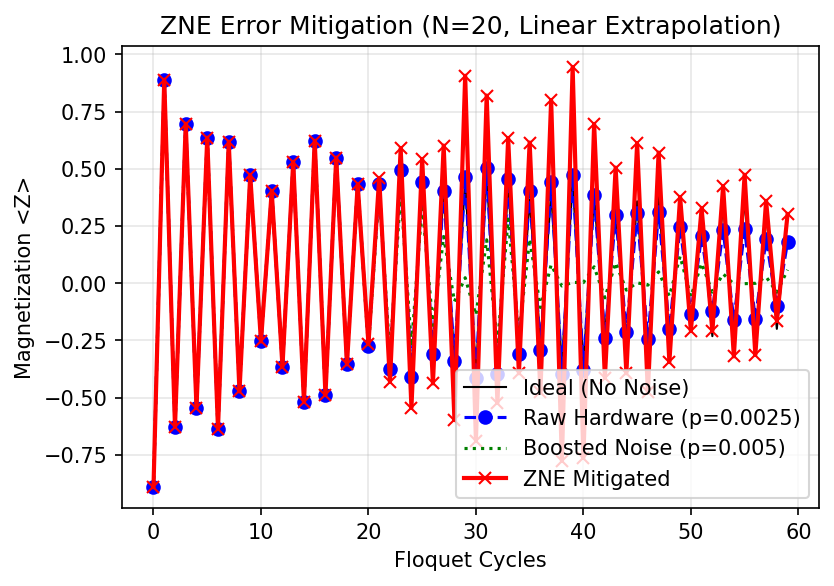

In [15]:
# Visualization
cycles = range(CYCLES)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot raw data
plt.plot(cycles, results['clean'], 'k-', alpha=1, linewidth=1, label='Ideal (No Noise)')
plt.plot(cycles, results['scale1'], 'b--o', alpha=1, label=f'Raw Hardware (p={BASE_NOISE_PROB})')
plt.plot(cycles, results['scale2'], 'g:', alpha=1, label=f'Boosted Noise (p={BASE_NOISE_PROB*2})')

# Plot ZNE Result
plt.plot(cycles, results['zne'], 'r-x', linewidth=2, label='ZNE Mitigated')

plt.xlabel('Floquet Cycles')
plt.ylabel('Magnetization <Z>')
plt.title(f'ZNE Error Mitigation (N={N}, Linear Extrapolation)')
plt.legend(loc = 'lower right')
plt.grid(True, alpha=0.3)
plt.show()

In the above ZNE overshoots because of variance and no ensemble averaging, so let's try to fix that with averaging.

In [21]:
N = 20
CYCLES = 60
BOND_DIM = 64
BASE_NOISE_PROB = 0.0025
SHOTS = 20

J_coupling = 0.3
epsilon = 0.15
W_disorder = 3.0

h_fields = (np.random.rand(N) - 0.5) * 2 * W_disorder

def get_Rx_matrix(theta):
    val = theta / 2.0
    return cp.array([[cp.cos(val), -1j * cp.sin(val)],
                     [-1j * cp.sin(val), cp.cos(val)]], dtype=complex)

def get_Rzz_matrix(theta):
    val = theta / 2.0
    e_minus = cp.exp(-1j * val)
    e_plus = cp.exp(1j * val)
    return cp.diag(cp.array([e_minus, e_plus, e_plus, e_minus], dtype=complex))

def get_Rz_matrix(theta):
    val = theta / 2.0
    e_m = cp.exp(-1j * val)
    e_p = cp.exp(1j * val)
    return cp.diag(cp.array([e_m, e_p], dtype=complex))

def apply_floquet_layer(mps, noise_prob=0.0):
    rx_gate = get_Rx_matrix(np.pi * (1.0 - epsilon))
    noise_gate = cp.asarray(qu.pauli('X'))

    for i in range(N):
        mps.gate_(rx_gate, i, tags={'Rx'}, contract=True)

        rz_disorder = get_Rz_matrix(h_fields[i] * np.pi)
        mps.gate_(rz_disorder, i, tags={'Disorder'}, contract=True)

        if noise_prob > 0 and np.random.rand() < noise_prob:
            mps.gate_(noise_gate, i, tags={'NOISE'}, contract=True)

    rzz_gate = get_Rzz_matrix(2 * J_coupling * np.pi)

    for i in range(N - 1):
        mps.gate_(rzz_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)

    mps.compress(max_bond=BOND_DIM, cutoff=1e-6)
    return mps

mps_clean = qtn.MPS_computational_state('0' * N)
mps_clean.apply_to_arrays(cp.asarray)

mps_scale1_list = []
mps_scale2_list = []

for _ in range(SHOTS):
    m1 = qtn.MPS_computational_state('0' * N)
    m2 = qtn.MPS_computational_state('0' * N)
    m1.apply_to_arrays(cp.asarray)
    m2.apply_to_arrays(cp.asarray)
    mps_scale1_list.append(m1)
    mps_scale2_list.append(m2)

results = {'clean': [], 'scale1': [], 'scale2': [], 'zne': []}
Z_op = cp.asarray(qu.pauli('Z'))

for t in tqdm(range(CYCLES)):
    mps_clean = apply_floquet_layer(mps_clean, noise_prob=0.0)

    for i in range(SHOTS):
        mps_scale1_list[i] = apply_floquet_layer(mps_scale1_list[i], noise_prob=BASE_NOISE_PROB)
        mps_scale2_list[i] = apply_floquet_layer(mps_scale2_list[i], noise_prob=BASE_NOISE_PROB * 2.0)

    psi_prime_clean = mps_clean.gate(Z_op, N//2, contract=True)
    val_clean = float(mps_clean.overlap(psi_prime_clean, optimize='auto-hq').real)

    vals_s1_shots = []
    for mps in mps_scale1_list:
        psi_prime = mps.gate(Z_op, N//2, contract=True)
        vals_s1_shots.append(float(mps.overlap(psi_prime, optimize='auto-hq').real))
    val_s1 = np.mean(vals_s1_shots)

    vals_s2_shots = []
    for mps in mps_scale2_list:
        psi_prime = mps.gate(Z_op, N//2, contract=True)
        vals_s2_shots.append(float(mps.overlap(psi_prime, optimize='auto-hq').real))
    val_s2 = np.mean(vals_s2_shots)

    v_zne = 2 * val_s1 - val_s2

    results['clean'].append(val_clean)
    results['scale1'].append(val_s1)
    results['scale2'].append(val_s2)
    results['zne'].append(v_zne)

print('Simulation complete')

100%|██████████| 60/60 [11:22<00:00, 11.38s/it]

Simulation complete


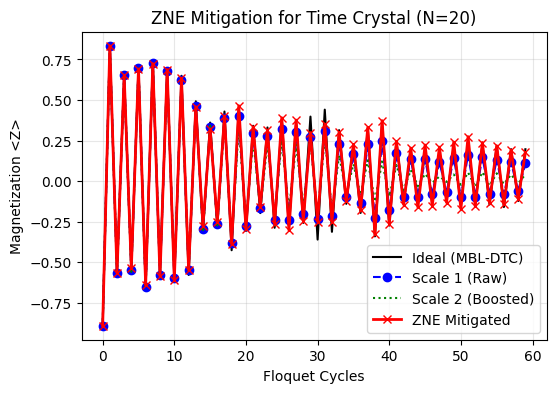

In [22]:
cycles = range(CYCLES)
plt.figure(figsize=(6, 4))

plt.plot(cycles, results['clean'], 'k-', alpha=1, linewidth=1.5, label='Ideal (MBL-DTC)')
plt.plot(cycles, results['scale1'], 'b--o', alpha=1, label='Scale 1 (Raw)')
plt.plot(cycles, results['scale2'], 'g:', alpha=1, label='Scale 2 (Boosted)')
plt.plot(cycles, results['zne'], 'r-x', linewidth=2, label='ZNE Mitigated')

plt.xlabel('Floquet Cycles')
plt.ylabel('Magnetization <Z>')
plt.title(f'ZNE Mitigation for Time Crystal (N={N})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# GPU Benchmarking:

GPU Memory Cleared.
--- Benchmarking NUMPY ---
  Cycle 1: 21.2687s
  Cycle 2: 22.6741s
  Cycle 3: 18.3549s
  Cycle 4: 20.7983s
  Cycle 5: 18.7036s
Average: 20.3599s

--- Benchmarking CUPY ---
  Cycle 1: 12.6224s
  Cycle 2: 6.5634s
  Cycle 3: 6.9580s
  Cycle 4: 6.2636s
  Cycle 5: 6.2110s
Average: 7.7237s



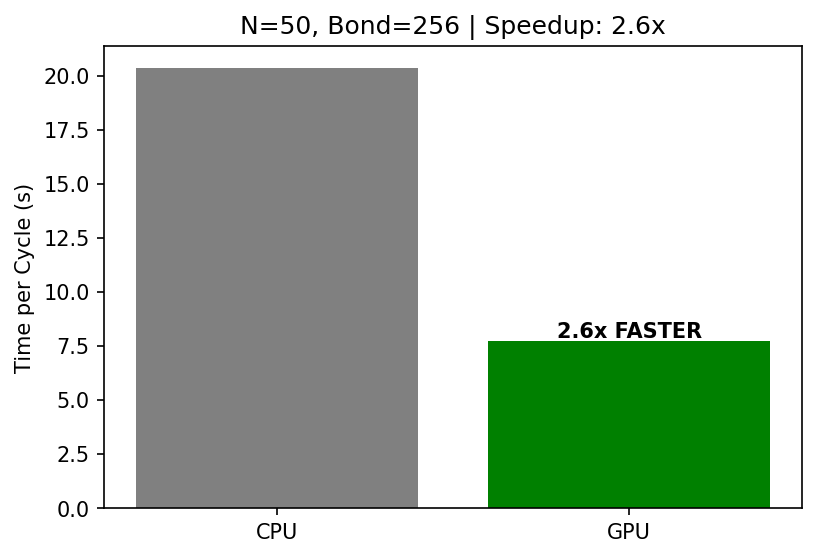

In [23]:
# Test configuration
N = 50
CYCLES_TO_TEST = 5
BOND_DIM = 256

# Clean GPU memory
gc.collect()
cp.get_default_memory_pool().free_all_blocks()
print("GPU Memory Cleared.")

def get_gpu_memory():
    try:
        nvmlInit()
        h = nvmlDeviceGetHandleByIndex(0)
        return nvmlDeviceGetMemoryInfo(h).used / 1024**2
    except: return 0

def run_benchmark(backend='numpy'):
    xp = cp if backend == 'cupy' else np

    print(f"--- Benchmarking {backend.upper()} ---")

    # Start with a random state at max bond dimension
    # This forces the tensors to be size (256, 256, 2) immediately.
    mps = qtn.MPS_rand_state(N, bond_dim=BOND_DIM)
    mps.apply_to_arrays(xp.asarray)
    mps.right_canonize() # distinct from canonicalize

    # Pre-generate random unitary gate
    G_2q = qu.rand_uni(4)
    if backend == 'cupy':
        G_2q = cp.asarray(G_2q)

    times = []

    if backend == 'cupy':
        mps.gate_(G_2q, (0, 1), contract='swap+split', max_bond=BOND_DIM)
        cp.cuda.Stream.null.synchronize()

    for t in range(CYCLES_TO_TEST):
        t0 = time.time()

        # Apply Entangling Gates across the chain
        for i in range(N-1):
            mps.gate_(G_2q, (i, i+1), contract='swap+split', max_bond=BOND_DIM)

        if backend == 'cupy':
            cp.cuda.Stream.null.synchronize()

        t1 = time.time()
        times.append(t1 - t0)

        # Print progress to confirm it's not hanging
        print(f"  Cycle {t+1}: {times[-1]:.4f}s")

    avg_time = np.mean(times)
    print(f"Average: {avg_time:.4f}s\n")
    return avg_time

# comparison
cpu_time = run_benchmark('numpy')
gpu_time = run_benchmark('cupy')

# plotting
speedup = cpu_time / gpu_time
plt.figure(figsize=(6, 4), dpi = 150)
plt.bar(['CPU', 'GPU'], [cpu_time, gpu_time], color=['gray', 'green'])
plt.ylabel('Time per Cycle (s)')
plt.title(f'N={N}, Bond={BOND_DIM} | Speedup: {speedup:.1f}x')
plt.text(1, gpu_time, f"{speedup:.1f}x FASTER", ha='center', va='bottom', fontweight='bold')
plt.show()

# More analysis and plots:

In [24]:
#Configuration and Hamiltonian parameters
N = 20
CYCLES = 60
BOND_DIM = 64

J_mean = 0.3
h_disorder = 3.0    # Strong disorder strength
epsilon = 0.10      # Drive perturbation

np.random.seed(42)
disorder_fields = np.random.uniform(-h_disorder, h_disorder, size=N)

# Define gate (GPU)
def get_Rx_matrix(theta):
    val = theta / 2.0
    return cp.array([[cp.cos(val), -1j * cp.sin(val)],
                     [-1j * cp.sin(val), cp.cos(val)]], dtype=complex)

def get_Rzz_matrix(theta):
    val = theta / 2.0
    e_minus = cp.exp(-1j * val)
    e_plus = cp.exp(1j * val)
    return cp.diag(cp.array([e_minus, e_plus, e_plus, e_minus], dtype=complex))

def get_Rz_matrix(theta):
    val = theta / 2.0
    # Diagonal Z-rotation for disorder
    return cp.diag(cp.array([cp.exp(-1j*val), cp.exp(1j*val)], dtype=complex))

def apply_floquet_layer(mps):
    angle_x = np.pi * (1.0 - epsilon)
    rx_gate = get_Rx_matrix(angle_x)

    for i in range(N):
        mps.gate_(rx_gate, i, tags={'Rx'}, contract=True)

    theta_J = 2 * J_mean * np.pi
    rzz_gate = get_Rzz_matrix(theta_J)

    # Apply Even/Odd layers to minimize Trotter error
    for i in range(0, N-1, 2):
        mps.gate_(rzz_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)
    for i in range(1, N-1, 2):
        mps.gate_(rzz_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)

    for i in range(N):
        angle_z = disorder_fields[i] * np.pi
        rz_gate = get_Rz_matrix(angle_z)
        mps.gate_(rz_gate, i, tags={'Disorder'}, contract=True)

    mps.compress(max_bond=BOND_DIM, cutoff=1e-6)
    return mps

# Start in Neel state |010101...>
init_string = "".join(["0" if i % 2 == 0 else "1" for i in range(N)])
mps = qtn.MPS_computational_state(init_string)

# Move to GPU
mps.apply_to_arrays(cp.asarray)
mps.right_canonize()

magnetization_trace = []
entanglement_trace = []

print(f"Simulating {CYCLES} Cycles on GPU...")
Z_op = cp.asarray(qu.pauli('Z'))

for t in range(CYCLES):
    # Measure Magnetization (Using Overlap Method)
    # We calculate <Z> for every site and average them
    site_mags = []

    for i in range(N):
        # Apply Z gate temporarily
        psi_prime = mps.gate(Z_op, i, contract=True)
        val = float(mps.overlap(psi_prime, optimize='auto-hq').real)

        # Correct for Neel initialization: (-1)^i
        # This aligns all spins so +1.0 means "State Preserved"
        ref_sign = 1.0 if i % 2 == 0 else -1.0
        site_mags.append(val * ref_sign)

    avg_mag = np.mean(site_mags)
    magnetization_trace.append(avg_mag)

    # Measure Entanglement Entrop
    try:
        S = mps.entropy(N//2)
        entanglement_trace.append(float(S))
    except:
        entanglement_trace.append(0.0) # Fallback if SVD fails (rare)

    # Evolve
    mps = apply_floquet_layer(mps)

print('simulation complete')

Simulating 60 Cycles on GPU...


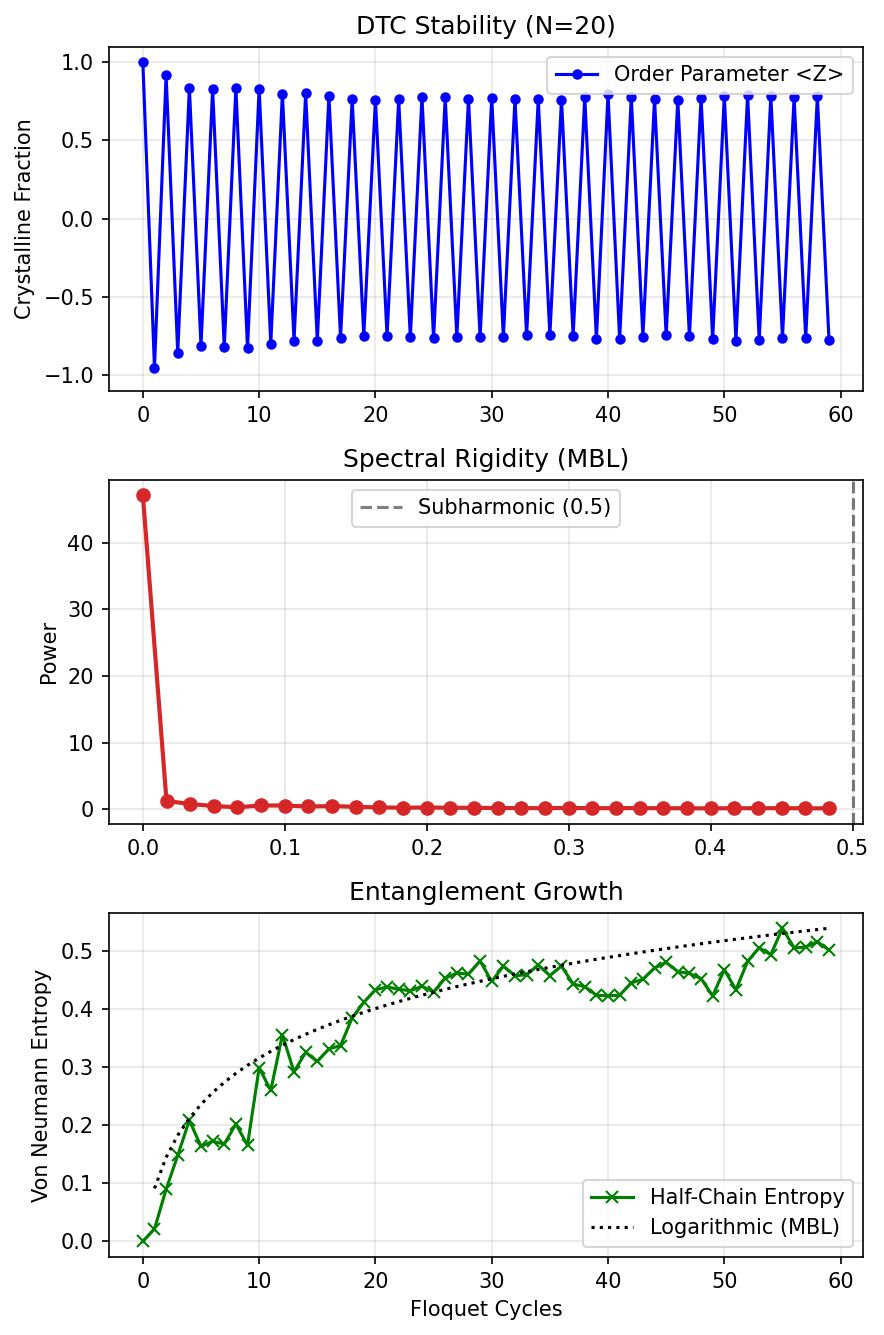

In [29]:
t_axis = np.arange(CYCLES)
raw_signal = np.array(magnetization_trace) * ((-1.0)**t_axis)
fft_vals = np.abs(fft(raw_signal))[:CYCLES//2]
freqs = fftfreq(CYCLES, 1.0)[:CYCLES//2]

mag_cpu = np.array(magnetization_trace)
ent_cpu = np.array(entanglement_trace)
fft_cpu = np.array(fft_vals)
freq_cpu = np.array(freqs)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 9), dpi = 150)

ax1.plot(t_axis, mag_cpu, 'b-o', markersize=4, label='Order Parameter <Z>')
ax1.set_title(f"DTC Stability (N={N})")
ax1.set_ylabel("Crystalline Fraction")
ax1.set_ylim(-1.1, 1.1)
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(freq_cpu, fft_cpu, 'o-', color = 'tab:red', linewidth=2)
ax2.axvline(0.5, color='k', linestyle='--', alpha=0.5, label='Subharmonic (0.5)')
ax2.set_title("Spectral Rigidity (MBL)")
ax2.set_ylabel("Power")
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.plot(t_axis, ent_cpu, 'g-x', label='Half-Chain Entropy')
ax3.set_title("Entanglement Growth")
ax3.set_xlabel("Floquet Cycles")
ax3.set_ylabel("Von Neumann Entropy")

if CYCLES > 1:
    scale_factor = np.max(ent_cpu) / np.log(CYCLES) if np.max(ent_cpu) > 0 else 0.5
    log_guide = scale_factor * np.log(t_axis[1:] + 1)
    ax3.plot(t_axis[1:], log_guide, 'k:', label='Logarithmic (MBL)')

ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Attempt at MBL phase transition:

Following needs more parameter tuning and possibly larger size system to see a clear phase transition

Running Disorder Strength h = 0.5...
Running Disorder Strength h = 1.5...
Running Disorder Strength h = 3.0...
Running Disorder Strength h = 5.0...


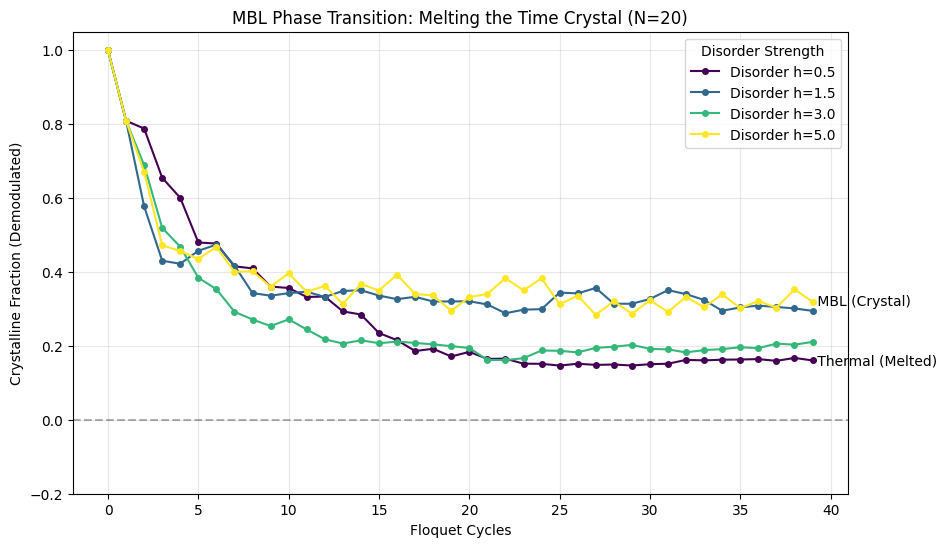

In [30]:
N = 20
CYCLES = 40
BOND_DIM = 64
DT = 1.0

J_mean = 0.3
epsilon = 0.10*2
h_values = [0.5, 1.5, 3.0, 5.0]

def get_Rx_matrix(theta):
    val = theta / 2.0
    return cp.array([[cp.cos(val), -1j * cp.sin(val)],
                     [-1j * cp.sin(val), cp.cos(val)]], dtype=complex)

def get_Rzz_matrix(theta):
    val = theta / 2.0
    e_minus = cp.exp(-1j * val)
    e_plus = cp.exp(1j * val)
    return cp.diag(cp.array([e_minus, e_plus, e_plus, e_minus], dtype=complex))

def get_Rz_matrix(theta):
    val = theta / 2.0
    return cp.diag(cp.array([cp.exp(-1j*val), cp.exp(1j*val)], dtype=complex))

def apply_floquet_layer(mps, disorder_fields):
    angle_x = np.pi * (1.0 - epsilon)
    rx_gate = get_Rx_matrix(angle_x)
    for i in range(N):
        mps.gate_(rx_gate, i, tags={'Rx'}, contract=True)

    theta_J = 2 * J_mean * np.pi
    rzz_gate = get_Rzz_matrix(theta_J)
    for i in range(0, N-1, 2):
        mps.gate_(rzz_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)
    for i in range(1, N-1, 2):
        mps.gate_(rzz_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)

    for i in range(N):
        angle_z = disorder_fields[i] * np.pi
        rz_gate = get_Rz_matrix(angle_z)
        mps.gate_(rz_gate, i, tags={'Disorder'}, contract=True)

    mps.compress(max_bond=BOND_DIM, cutoff=1e-6)
    return mps

def run_simulation(h_strength):
    print(f"Running Disorder Strength h = {h_strength}...")

    # Generate new disorder realization for this 'h'
    np.random.seed(42)
    current_fields = np.random.uniform(-h_strength, h_strength, size=N)

    # Initialize Neel State
    init_string = "".join(["0" if i % 2 == 0 else "1" for i in range(N)])
    mps = qtn.MPS_computational_state(init_string)
    mps.apply_to_arrays(cp.asarray)
    mps.right_canonize()

    Z_op = cp.asarray(qu.pauli('Z'))
    trace = []

    for t in range(CYCLES):
        # Measure Magnetization
        site_mags = []
        for i in range(N):
            psi_prime = mps.gate(Z_op, i, contract=True)
            val = float(mps.overlap(psi_prime, optimize='auto-hq').real)
            # Rectify sign (-1)^i
            ref_sign = 1.0 if i % 2 == 0 else -1.0
            site_mags.append(val * ref_sign)

        # We also rectify the time oscillation (-1)^t to see the "envelope"
        avg_mag = np.mean(site_mags) * ((-1.0)**t)
        trace.append(avg_mag)

        mps = apply_floquet_layer(mps, current_fields)

    return trace


results = {}
for h in h_values:
    results[h] = run_simulation(h)

# Visualization
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(h_values)))

for (h, trace), color in zip(results.items(), colors):
    plt.plot(trace, 'o-', markersize=4, color=color, label=f'Disorder h={h}')

plt.title(f'MBL Phase Transition: Melting the Time Crystal (N={N})')
plt.xlabel('Floquet Cycles')
plt.ylabel('Crystalline Fraction (Demodulated)')
plt.ylim(-0.2, 1.05)
plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.legend(title="Disorder Strength")
plt.grid(True, alpha=0.3)

# Add Annotation
plt.text(CYCLES-1, results[h_values[0]][-1], " Thermal (Melted)", va='center')
plt.text(CYCLES-1, results[h_values[-1]][-1], " MBL (Crystal)", va='center')

plt.show()

# 2D structure:

Running Disorder Strength h = 0.5...
Running Disorder Strength h = 1.5...
Running Disorder Strength h = 3.0...
Running Disorder Strength h = 5.0...


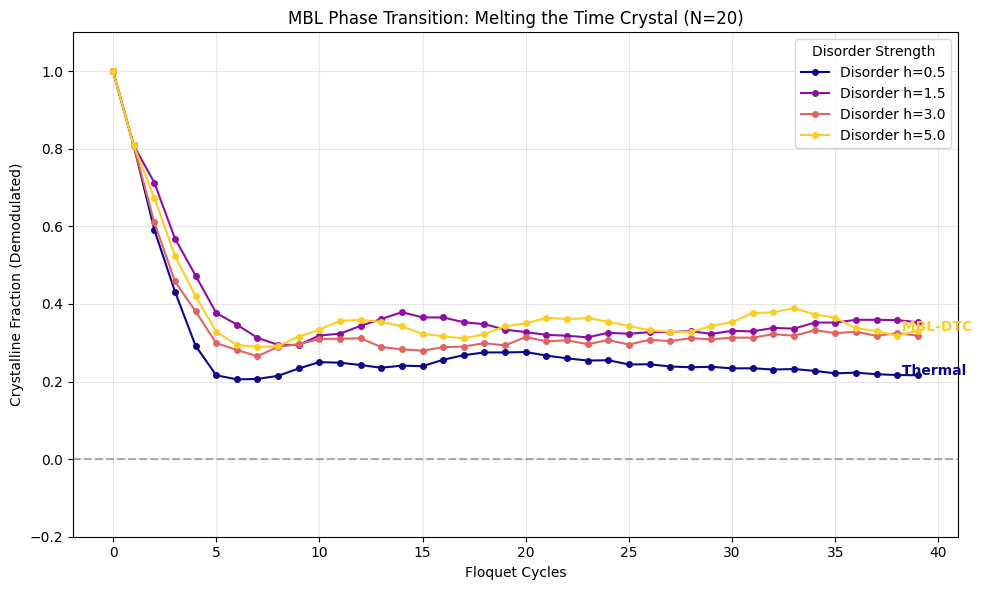

In [32]:
N = 20
CYCLES = 40
BOND_DIM = 64
DT = 1.0

J_mean = 0.3
epsilon = 0.10 * 2
h_values = [0.5, 1.5, 3.0, 5.0]

def get_Rx_matrix(theta):
    val = theta / 2.0
    return cp.array([[cp.cos(val), -1j * cp.sin(val)],
                     [-1j * cp.sin(val), cp.cos(val)]], dtype=complex)

def get_Rzz_matrix(theta):
    val = theta / 2.0
    e_minus = cp.exp(-1j * val)
    e_plus = cp.exp(1j * val)
    return cp.diag(cp.array([e_minus, e_plus, e_plus, e_minus], dtype=complex))

def get_Rz_matrix(theta):
    val = theta / 2.0
    return cp.diag(cp.array([cp.exp(-1j*val), cp.exp(1j*val)], dtype=complex))

def apply_floquet_layer(mps, disorder_fields):
    angle_x = np.pi * (1.0 - epsilon)
    rx_gate = get_Rx_matrix(angle_x)
    for i in range(N):
        mps.gate_(rx_gate, i, tags={'Rx'}, contract=True)

    theta_J = 2 * J_mean * np.pi
    rzz_gate = get_Rzz_matrix(theta_J)

    for i in range(0, N-1, 2):
        mps.gate_(rzz_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)
    for i in range(1, N-1, 2):
        mps.gate_(rzz_gate, (i, i+1), contract='swap+split', max_bond=BOND_DIM)

    WIDTH = 4
    for i in range(0, N - WIDTH, 2):
        mps.gate_(rzz_gate, (i, i+WIDTH), contract='swap+split', max_bond=BOND_DIM)

    for i in range(1, N - WIDTH, 2):
        mps.gate_(rzz_gate, (i, i+WIDTH), contract='swap+split', max_bond=BOND_DIM)

    for i in range(N):
        angle_z = disorder_fields[i] * np.pi
        rz_gate = get_Rz_matrix(angle_z)
        mps.gate_(rz_gate, i, tags={'Disorder'}, contract=True)

    mps.compress(max_bond=BOND_DIM, cutoff=1e-6)
    return mps

def run_simulation(h_strength):
    print(f"Running Disorder Strength h = {h_strength}...")

    np.random.seed(42)
    current_fields = np.random.uniform(-1, 1, size=N) * h_strength

    init_string = "".join(["0" if i % 2 == 0 else "1" for i in range(N)])
    mps = qtn.MPS_computational_state(init_string)
    mps.apply_to_arrays(cp.asarray)
    mps.right_canonize()

    Z_op = cp.asarray(qu.pauli('Z'))
    trace = []

    for t in range(CYCLES):
        site_mags = []

        # FIXED: Use overlap(mps) to get the scalar value, not make_norm()
        norm_sq = mps.overlap(mps).real

        for i in range(N):
            psi_prime = mps.gate(Z_op, i, contract=True)
            val = float(mps.overlap(psi_prime, optimize='auto-hq').real / norm_sq)

            ref_sign = 1.0 if i % 2 == 0 else -1.0
            site_mags.append(val * ref_sign)

        avg_mag = np.mean(site_mags) * ((-1.0)**t)
        trace.append(avg_mag)

        mps = apply_floquet_layer(mps, current_fields)

    return trace

results = {}
for h in h_values:
    results[h] = run_simulation(h)

plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0, 0.9, len(h_values)))

for (h, trace), color in zip(results.items(), colors):
    plt.plot(trace, 'o-', markersize=4, color=color, label=f'Disorder h={h}')

plt.title(f'MBL Phase Transition: Melting the Time Crystal (N={N})')
plt.xlabel('Floquet Cycles')
plt.ylabel('Crystalline Fraction (Demodulated)')
plt.ylim(-0.2, 1.1)
plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.legend(title="Disorder Strength")
plt.grid(True, alpha=0.3)

plt.text(CYCLES-2, results[h_values[0]][-1], " Thermal", color=colors[0], fontweight='bold')
plt.text(CYCLES-2, results[h_values[-1]][-1], " MBL-DTC", color=colors[-1], fontweight='bold')

plt.tight_layout()
plt.show()

# VQE with MPS:

GPU Memory Cleared.
Defining Hamiltonian (N=12)...
Starting GPU-Native Adam-SPSA Optimization (100 iterations)...
  Iter 0: Loss = 1.3999
  Iter 10: Loss = -2.7379
  Iter 20: Loss = -5.6337
  Iter 30: Loss = -7.7999
  Iter 40: Loss = -9.7440
  Iter 50: Loss = -11.4197
  Iter 60: Loss = -13.0034
  Iter 70: Loss = -14.3508
  Iter 80: Loss = -15.1308
  Iter 90: Loss = -15.9941

Optimization Complete. Verifying Physics...
Ground State Energy:   -10.8990
Excited State Energy:  -7.9620
Spectral Gap:          2.9371


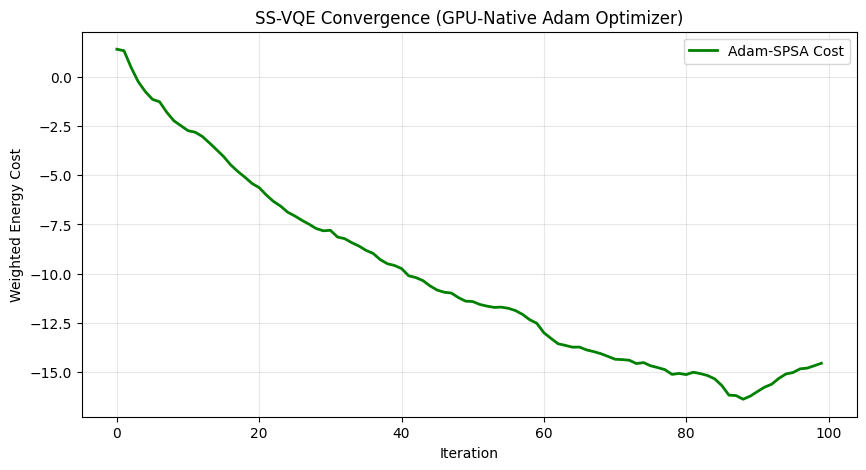

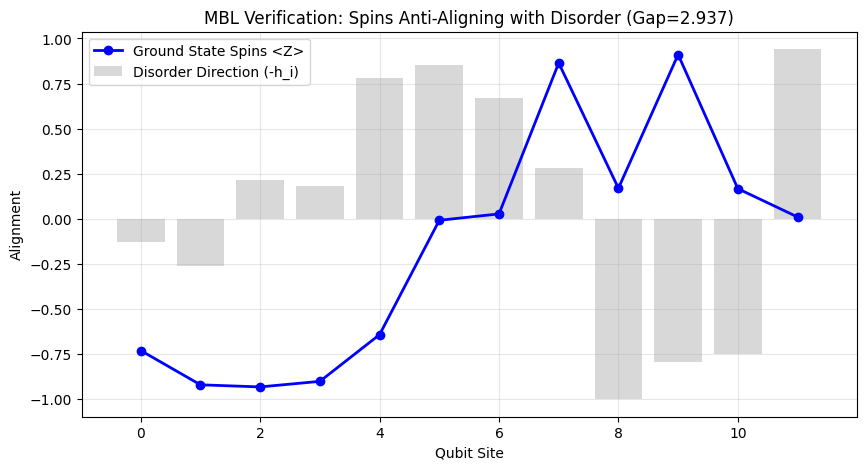

In [33]:
gc.collect()
cp.get_default_memory_pool().free_all_blocks()
print("GPU Memory Cleared.")

# Confuguration
N = 12                  # System Size (Simulating 12 Qubits on GPU)
BOND_DIM = 48           # MPS Bond Dimension (Accuracy)
J = 1.0                 # Interaction Strength
h_disorder_strength = 2.0 # Disorder Strength (MBL Regime)

# SS-VQE Weights (w0 > w1 ensures State 0 is Ground, State 1 is Excited)
w0 = 1.0
w1 = 0.5

print(f"Defining Hamiltonian (N={N})...")
cp.random.seed(42)

# Generate disorder directly on GPU memory
disorder_fields = cp.random.uniform(-h_disorder_strength, h_disorder_strength, size=N)

# Pre-allocate GPU Operators for speed
ZZ_OP = cp.asarray(qu.pauli('Z') & qu.pauli('Z'))
X_OP = cp.asarray(qu.pauli('X'))

def get_energy_gpu(mps, disorder_gpu):
    """
    Computes energy <psi|H|psi> entirely on GPU.
    Returns a CuPy scalar (keeps data on VRAM).
    """
    E_total = cp.array(0.0, dtype=float)

    # Nearest Neighbor Interaction (-J * ZZ)
    for i in range(N-1):
        # Create temporary state H|psi>
        psi_H = mps.gate(ZZ_OP, (i, i+1), contract=True)
        # Measure overlap <psi | H | psi>
        val = mps.overlap(psi_H, optimize='auto-hq')
        E_total += (-J * val.real)

    # Disordered Transverse Fields (h_i * X_i)
    for i in range(N):
        psi_H = mps.gate(X_OP, i, contract=True)
        val = mps.overlap(psi_H, optimize='auto-hq')
        E_total += (disorder_gpu[i] * val.real)

    return E_total

# create ansatz (GPU)
# Pre-allocate Constant Gates (CZ)
CZ_MAT = cp.diag(cp.array([1,1,1,-1], dtype=complex))

def apply_ansatz(mps, params_gpu):
    # params_gpu is a CuPy array of rotation angles
    depth = 3
    idx = 0

    for d in range(depth):
        # Rotation Layer (Ry)
        for i in range(N):
            theta = params_gpu[idx]
            idx += 1
            # Compute Rotation Matrix on GPU manually
            c = cp.cos(theta/2)
            s = cp.sin(theta/2)
            Ry = cp.array([[c, -s], [s, c]], dtype=complex)
            mps.gate_(Ry, i, contract=True)

        # Entanglement Layer (CZ) - Even/Odd breakdown
        for i in range(0, N-1, 2):
            mps.gate_(CZ_MAT, (i, i+1), contract='swap+split', max_bond=BOND_DIM)
        for i in range(1, N-1, 2):
            mps.gate_(CZ_MAT, (i, i+1), contract='swap+split', max_bond=BOND_DIM)

    return mps

# cost function
def cost_function(params_gpu):
    # Create Initial Orthogonal States |00...0> and |00...1>
    mps0 = qtn.MPS_computational_state("0"*N)
    mps1 = qtn.MPS_computational_state("0"*(N-1) + "1")

    # Move to GPU (In-place)
    mps0.apply_to_arrays(cp.asarray)
    mps1.apply_to_arrays(cp.asarray)

    # Apply Ansatz (Unitary preserves orthogonality)
    mps0 = apply_ansatz(mps0, params_gpu)
    mps1 = apply_ansatz(mps1, params_gpu)

    # Compute Energies
    E0 = get_energy_gpu(mps0, disorder_fields)
    E1 = get_energy_gpu(mps1, disorder_fields)

    # Weighted Sum (The SS-VQE Objective)
    return (w0 * E0) + (w1 * E1)

# custom Adam on GPU
class GPUAdamOptimizer:
    """
    Implements the Adam algorithm (Kingma & Ba) natively on CuPy.
    State-of-the-art optimization without leaving the GPU.
    """
    def __init__(self, params_shape, lr=0.05, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

        # Initialize Moment Vectors on VRAM
        self.m = cp.zeros(params_shape) # Momentum
        self.v = cp.zeros(params_shape) # Velocity (Variance)

    def step(self, params, grads):
        self.t += 1

        # Update biased first moment estimate
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads

        # Update biased second raw moment estimate
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = self.m / (1 - self.beta1 ** self.t)

        # Compute bias-corrected second raw moment estimate
        v_hat = self.v / (1 - self.beta2 ** self.t)

        # Update parameters
        update = self.lr * m_hat / (cp.sqrt(v_hat) + self.epsilon)
        new_params = params - update

        return new_params

def run_adam_spsa_optimization(cost_fn, init_params, max_iter=100):
    """
    Combines SPSA Gradient Estimation with Adam Optimization.
    """
    # Initialize Optimizer
    optimizer = GPUAdamOptimizer(init_params.shape, lr=0.1)
    theta = cp.array(init_params, copy=True)

    # SPSA Hyperparameter (Perturbation Size)
    c = 0.1

    history = []
    print(f"Starting GPU-Native Adam-SPSA Optimization ({max_iter} iterations)...")

    for k in range(max_iter):
        # Decay perturbation size
        ck = c / (k + 1)**0.101

        # SPSA gradient estimate
        # Generate random perturbation vector (+/- 1)
        delta = (cp.random.randint(0, 2, theta.shape) * 2 - 1).astype(float)

        # Measure Cost
        loss_plus = cost_fn(theta + ck * delta)
        loss_minus = cost_fn(theta - ck * delta)

        # Estimate Gradient: g = (y+ - y-) / (2 * ck * delta)
        grad_estimate = (loss_plus - loss_minus) / (2 * ck) * delta

        # Adam Update
        theta = optimizer.step(theta, grad_estimate)

        # Logging
        current_loss = (loss_plus + loss_minus) / 2
        history.append(current_loss)

        if k % 10 == 0:
            print(f"  Iter {k}: Loss = {float(current_loss):.4f}")

    return theta, history

# Initialize Parameters on CPU first
num_params = 3 * N
init_params_cpu = np.random.uniform(0, 2*np.pi, num_params)

# Run Optimization
opt_params_gpu, loss_history = run_adam_spsa_optimization(
    cost_function,
    init_params_cpu,
    max_iter=100
)

# results
print("\nOptimization Complete. Verifying Physics...")

# Reconstruct Final States (Robustly)
mps0_final = qtn.MPS_computational_state("0"*N)
mps1_final = qtn.MPS_computational_state("0"*(N-1) + "1")

# Move to GPU
mps0_final.apply_to_arrays(cp.asarray)
mps1_final.apply_to_arrays(cp.asarray)

# Apply Optimized Ansatz
mps0_final = apply_ansatz(mps0_final, opt_params_gpu)
mps1_final = apply_ansatz(mps1_final, opt_params_gpu)

# Calculate Final Energies
E0 = float(get_energy_gpu(mps0_final, disorder_fields))
E1 = float(get_energy_gpu(mps1_final, disorder_fields))
Gap = E1 - E0

print(f"Ground State Energy:   {E0:.4f}")
print(f"Excited State Energy:  {E1:.4f}")
print(f"Spectral Gap:          {Gap:.4f}")

# Visualization
# Plot 1: Convergence
loss_cpu = [float(x) for x in loss_history]
plt.figure(figsize=(10, 5))
plt.plot(loss_cpu, 'g-', linewidth=2, label='Adam-SPSA Cost')
plt.title(f"SS-VQE Convergence (GPU-Native Adam Optimizer)")
plt.xlabel("Iteration")
plt.ylabel("Weighted Energy Cost")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("convergence_adam.png")
plt.show()

# Plot 2: Spin Profile Verification
z_exp_0 = []
Z_op = cp.asarray(qu.pauli('Z'))

for i in range(N):
    psi_p = mps0_final.gate(Z_op, i, contract=True)
    val = mps0_final.overlap(psi_p, optimize='auto-hq')
    z_exp_0.append(float(val.real))

# Overlay Disorder for Visual Proof
fields_cpu = disorder_fields.get()
fields_norm = fields_cpu / np.max(np.abs(fields_cpu))

plt.figure(figsize=(10, 5))
plt.bar(range(N), -fields_norm, color='gray', alpha=0.3, label='Disorder Direction (-h_i)')
plt.plot(z_exp_0, 'b-o', linewidth=2, label='Ground State Spins <Z>')
plt.title(f"MBL Verification: Spins Anti-Aligning with Disorder (Gap={Gap:.3f})")
plt.xlabel("Qubit Site")
plt.ylabel("Alignment")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("verification_plot.png")
plt.show()

# Sample based quantum diagonalization (SQD) with MPS:

STATUS: GPU (CuPy) detected. Tensor operations will be accelerated.

[1] Generating Ansatz (N=14, g=1.0)...


t=2, max-bond=4: 100%|##########| 100/100 [00:01<00:00, 55.59%/s]


[2] Sampling 2000 configurations...
    Unique Basis States: 1673 (Compression: 83.65%)
[3] Constructing Projected Hamiltonian (1673x1673)...
[4] Diagonalizing Subspace...

--- Results (N=14) ---
Ground State Energy: -15.930367
Energy per site:     -1.137883
Hamiltonian Sparsity: 0.2295%
Total Time:          17.98s


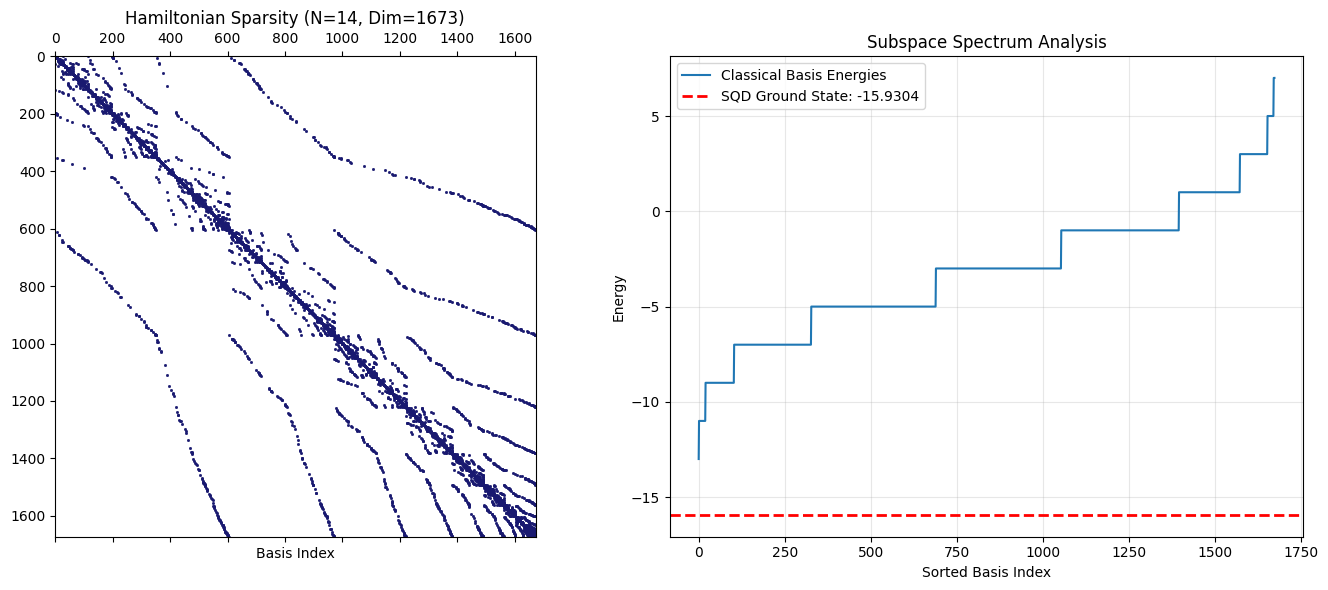

In [ ]:
# Check for GPU
try:
    import cupy as cp
    GPU_AVAILABLE = True
    print("STATUS: GPU (CuPy) detected. Tensor operations will be accelerated.")
except ImportError:
    GPU_AVAILABLE = False
    print("STATUS: GPU not found. Falling back to CPU.")

# the SQD solver class
class SQD_Solver:
    def __init__(self, N, J, g, samples=2000, chi=16, dt=0.1, t_max=2.0):
        self.N = N
        self.J = J
        self.g = g
        self.num_samples = samples
        self.chi = chi
        self.dt = dt
        self.t_max = t_max
        self.basis_map = {}
        self.basis_states = []

    def build_ansatz(self):
        """Generates trial state using TEBD."""
        print(f"\n[1] Generating Ansatz (N={self.N}, g={self.g})...")

        # Initialize State |00...0>
        psi0 = qtn.MPS_computational_state('0' * self.N)

        # Build Hamiltonian (Local terms for TEBD)
        builder = qtn.SpinHam1D(S=0.5)
        builder += self.J, 'Z', 'Z'
        builder += self.g, 'X'

        # Use build_local_ham() for TEBD compatibility
        H_local = builder.build_local_ham(self.N)

        # Setup TEBD
        tebd = qtn.TEBD(psi0, H_local)
        tebd.split_opts['cutoff'] = 1e-12
        tebd.split_opts['max_bond'] = self.chi

        # Evolve using update_to (robust API)
        tebd.update_to(self.t_max, dt=self.dt)

        psi_t = tebd.pt
        psi_t.left_canonicalize()
        return psi_t

    def _flatten_sample(self, s):
        """Recursively flattens nested structures."""
        flat = []
        for item in s:
            if isinstance(item, Iterable) and not isinstance(item, (str, bytes)):
                flat.extend(self._flatten_sample(item))
            else:
                flat.append(item)
        return tuple(flat)

    def sample_basis(self, psi):
        """Samples configurations and enforces size N."""
        print(f"[2] Sampling {self.num_samples} configurations...")

        # Move to CPU to prevent backend hashing errors
        psi_cpu = psi.copy()
        psi_cpu.apply_to_arrays(lambda x: x.get() if hasattr(x, 'get') else x)

        # Sample
        raw_samples = list(psi_cpu.sample(self.num_samples))

        unique_states = set()
        for s in raw_samples:
            # Flatten structure
            flat_s = self._flatten_sample(s)

            # Truncate to N
            if len(flat_s) > self.N:
                flat_s = flat_s[:self.N]

            if len(flat_s) != self.N:
                continue

            unique_states.add(flat_s)

        self.basis_states = sorted(list(unique_states))
        self.dim = len(self.basis_states)

        if self.dim == 0:
            raise ValueError("Sampling failed: 0 valid states found.")

        # Map for O(1) lookup
        self.basis_map = {state: i for i, state in enumerate(self.basis_states)}
        print(f"    Unique Basis States: {self.dim} (Compression: {self.dim/self.num_samples:.2%})")

    def build_projected_hamiltonian(self):
        """Constructs H_sub explicitly in the sampled basis."""
        print(f"[3] Constructing Projected Hamiltonian ({self.dim}x{self.dim})...")

        H_sub = sp.lil_matrix((self.dim, self.dim), dtype=np.float64)

        for i, state in enumerate(self.basis_states):
            # Map 0 -> +1 (Up), 1 -> -1 (Down)
            spins = np.array([1 if int(s) == 0 else -1 for s in state])

            # Diagonal: Ising Interaction
            if self.N > 1:
                e_diag = -self.J * np.sum(spins[:-1] * spins[1:])
            else:
                e_diag = 0.0
            H_sub[i, i] = e_diag

            # Off-Diagonal: Transverse Field (Bit flips)
            if abs(self.g) > 1e-10:
                state_list = list(state)
                for k in range(self.N):
                    # Flip bit k
                    original = state_list[k]
                    state_list[k] = 1 - int(original)
                    trial_tuple = tuple(state_list)

                    if trial_tuple in self.basis_map:
                        j = self.basis_map[trial_tuple]
                        H_sub[i, j] = -self.g

                    # Restore
                    state_list[k] = original

        return H_sub.tocsr()

    def solve(self):
        t0 = time.time()

        # Pipeline
        psi = self.build_ansatz()
        self.sample_basis(psi)
        H_sub = self.build_projected_hamiltonian()

        # Diagonalize
        print("[4] Diagonalizing Subspace...")
        eigvals, eigvecs = spla.eigsh(H_sub, k=1, which='SA')
        gs_energy = eigvals[0]

        density = H_sub.nnz / (self.dim**2) if self.dim > 0 else 0

        print(f"\n--- Results (N={self.N}) ---")
        print(f"Ground State Energy: {gs_energy:.6f}")
        print(f"Energy per site:     {gs_energy/self.N:.6f}")
        print(f"Hamiltonian Sparsity: {density:.4%}")
        print(f"Total Time:          {time.time()-t0:.2f}s")

        return H_sub, gs_energy

# execution
N_SITES = 14
J_CPL = 1.0
G_FIELD = 1.0
SAMPLES = 2000

solver = SQD_Solver(N_SITES, J_CPL, G_FIELD, samples=SAMPLES)
H_sub, E_gs = solver.solve()

# visualization
plt.figure(figsize=(14, 6))

# plot 1: Hamiltonian Structure
plt.subplot(1, 2, 1)
plt.spy(H_sub, markersize=1, color='midnightblue', rasterized=True)
plt.title(f"Hamiltonian Sparsity (N={N_SITES}, Dim={solver.dim})")
plt.xlabel("Basis Index")

# plot 2: Energy Spectrum
plt.subplot(1, 2, 2)
diagonals = np.sort(H_sub.diagonal())
plt.plot(diagonals, lw=1.5, label='Classical Basis Energies')
plt.axhline(E_gs, color='red', ls='--', lw=2, label=f'SQD Ground State: {E_gs:.4f}')
plt.legend()
plt.xlabel("Sorted Basis Index")
plt.ylabel("Energy")
plt.title("Subspace Spectrum Analysis")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


[SQD] Running SQD with AUGMENTATION...


t=2, max-bond=4: 100%|##########| 100/100 [00:02<00:00, 39.52%/s]


    Initial unique states: 473
    [Augmenting] Adding all 1-flip neighbors...
    Final Augmented Basis Size: 4987 (Growth factor: 10.54x)

[Exact] Building Full Hamiltonian (Dim=16384)...
[Exact] Diagonalizing...
[Exact] Finished in 2.69s

--- RESULTS (N=14) ---
Exact Energy:     -17.471004
SQD (Aug) Energy: -16.886032
Error:            5.849722e-01
Rel Error:        3.3482%


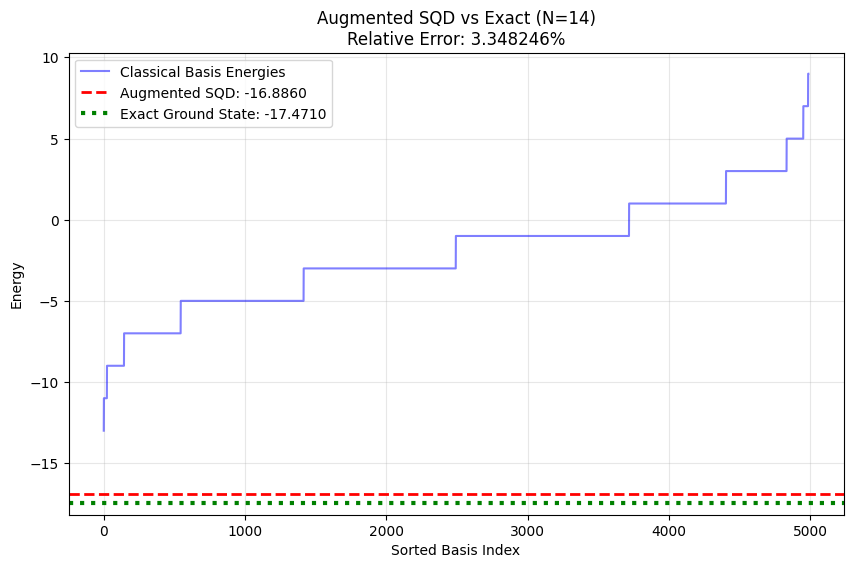

In [ ]:
# Exact Diagonalization
class Exact_Solver:
    def __init__(self, N, J, g):
        self.N = N
        self.J = J
        self.g = g
        self.dim = 2**N

    def get_exact_ground_state(self):
        print(f"\n[Exact] Building Full Hamiltonian (Dim={self.dim})...")
        t0 = time.time()

        # Diagonal (Ising)
        indices = np.arange(self.dim)
        energy_diag = np.zeros(self.dim)
        for k in range(self.N - 1):
            bit_k = (indices >> k) & 1
            bit_kplus1 = (indices >> (k+1)) & 1
            interaction = np.where(bit_k == bit_kplus1, -1.0, 1.0)
            energy_diag += self.J * interaction

        H_exact = sp.diags(energy_diag, 0, shape=(self.dim, self.dim), format='lil')

        # Off-Diagonal (Transverse Field)
        if abs(self.g) > 1e-10:
            for i in range(self.dim):
                for k in range(self.N):
                    j = i ^ (1 << k) # Flip bit k
                    H_exact[i, j] = -self.g

        print(f"[Exact] Diagonalizing...")
        eigvals, _ = spla.eigsh(H_exact, k=1, which='SA')
        print(f"[Exact] Finished in {time.time()-t0:.2f}s")
        return eigvals[0]

# SQD Solver class with augmentation
class SQD_Solver_Augmented:
    def __init__(self, N, J, g, samples=2000, chi=16, dt=0.1, t_max=2.0):
        self.N = N
        self.J = J
        self.g = g
        self.num_samples = samples
        self.chi = chi
        self.dt = dt
        self.t_max = t_max
        self.basis_states = []

    def build_ansatz(self):
        # Standard TEBD Ansatz generation
        psi0 = qtn.MPS_computational_state('0' * self.N)
        builder = qtn.SpinHam1D(S=0.5)
        builder += self.J, 'Z', 'Z'
        builder += self.g, 'X'
        H_local = builder.build_local_ham(self.N)
        tebd = qtn.TEBD(psi0, H_local)
        tebd.split_opts['cutoff'] = 1e-12
        tebd.split_opts['max_bond'] = self.chi
        tebd.update_to(self.t_max, dt=self.dt)
        psi_t = tebd.pt
        psi_t.left_canonicalize()
        return psi_t

    def _flatten_sample(self, s):
        flat = []
        for item in s:
            if isinstance(item, Iterable) and not isinstance(item, (str, bytes)):
                flat.extend(self._flatten_sample(item))
            else:
                flat.append(item)
        return tuple(flat)

    def solve(self):
        # 1. Sample
        print(f"\n[SQD] Running SQD with AUGMENTATION...")
        psi = self.build_ansatz()

        psi_cpu = psi.copy()
        psi_cpu.apply_to_arrays(lambda x: x.get() if hasattr(x, 'get') else x)

        raw_samples = list(psi_cpu.sample(self.num_samples))
        unique_states = set()

        # Initial Filtering
        for s in raw_samples:
            flat_s = self._flatten_sample(s)
            if len(flat_s) > self.N: flat_s = flat_s[:self.N]
            if len(flat_s) == self.N: unique_states.add(flat_s)

        print(f"    Initial unique states: {len(unique_states)}")

        # augmentation
        print(f"    [Augmenting] Adding all 1-flip neighbors...")
        augmented_states = set(unique_states)

        for state in unique_states:
            state_list = list(state)
            # Try flipping every single site for every state
            for k in range(self.N):
                # Flip
                state_list[k] = 1 - int(state_list[k])
                neighbor = tuple(state_list)

                # Add to set (automatically handles duplicates)
                augmented_states.add(neighbor)

                # Flip back
                state_list[k] = 1 - int(state_list[k])

        self.basis_states = sorted(list(augmented_states))
        dim = len(self.basis_states)
        basis_map = {state: i for i, state in enumerate(self.basis_states)}

        print(f"    Final Augmented Basis Size: {dim} (Growth factor: {dim/len(unique_states):.2f}x)")

        # Build Hamiltonian
        H_sub = sp.lil_matrix((dim, dim), dtype=np.float64)

        for i, state in enumerate(self.basis_states):
            spins = np.array([1 if int(s) == 0 else -1 for s in state])

            # Diagonal
            if self.N > 1:
                e_diag = -self.J * np.sum(spins[:-1] * spins[1:])
            else:
                e_diag = 0.0
            H_sub[i, i] = e_diag

            # Off-Diagonal
            if abs(self.g) > 1e-10:
                state_list = list(state)
                for k in range(self.N):
                    state_list[k] = 1 - int(state_list[k])
                    trial_tuple = tuple(state_list)

                    if trial_tuple in basis_map:
                        j = basis_map[trial_tuple]
                        H_sub[i, j] = -self.g

                    state_list[k] = 1 - int(state_list[k])

        # Diagonalize
        eigvals, _ = spla.eigsh(H_sub, k=1, which='SA')
        return H_sub, eigvals[0]

# Comparison run

# Parameters
N = 14
J = 1.0
g = 1.0
SAMPLES = 500 # Fewer initial samples needed since we augment

# Run SQD (Augmented)
sqd_solver = SQD_Solver_Augmented(N, J, g, samples=SAMPLES)
H_sqd, E_sqd = sqd_solver.solve()

# Run Exact Diagonalization
ed_solver = Exact_Solver(N, J, g)
E_exact = ed_solver.get_exact_ground_state()

# Plot Results

error = abs(E_sqd - E_exact)
rel_error = error / abs(E_exact)

print(f"\n--- RESULTS (N={N}) ---")
print(f"Exact Energy:     {E_exact:.6f}")
print(f"SQD (Aug) Energy: {E_sqd:.6f}")
print(f"Error:            {error:.6e}")
print(f"Rel Error:        {rel_error:.4%}")

plt.figure(figsize=(10, 6))
diagonals = np.sort(H_sqd.diagonal())
plt.plot(diagonals, color='blue', alpha=0.5, label='Classical Basis Energies')
plt.axhline(E_sqd, color='red', linestyle='--', linewidth=2, label=f'Augmented SQD: {E_sqd:.4f}')
plt.axhline(E_exact, color='green', linestyle=':', linewidth=3, label=f'Exact Ground State: {E_exact:.4f}')

plt.xlabel("Sorted Basis Index")
plt.ylabel("Energy")
plt.title(f"Augmented SQD vs Exact (N={N})\nRelative Error: {rel_error:.6%}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# SQD for MBL:

Starting Robust MBL Sweep (N=12)...


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 129.10%/s]


W=0.1 | IPR=0.023 | Error=1.85e-02


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 135.32%/s]


W=0.6 | IPR=0.032 | Error=1.65e-02


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 124.53%/s]


W=1.2 | IPR=0.024 | Error=2.74e-02


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 131.40%/s]


W=1.7 | IPR=0.040 | Error=2.98e-02


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 129.83%/s]


W=2.3 | IPR=0.055 | Error=5.00e-02


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 109.16%/s]


W=2.8 | IPR=0.077 | Error=1.28e-01


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 122.30%/s]


W=3.4 | IPR=0.101 | Error=2.08e-01


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 130.40%/s]


W=3.9 | IPR=0.127 | Error=2.72e-01


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 123.84%/s]


W=4.5 | IPR=0.153 | Error=2.66e-01


t=2, max-bond=4: 100%|##########| 100/100 [00:00<00:00, 131.52%/s]


W=5.0 | IPR=0.179 | Error=3.14e-01


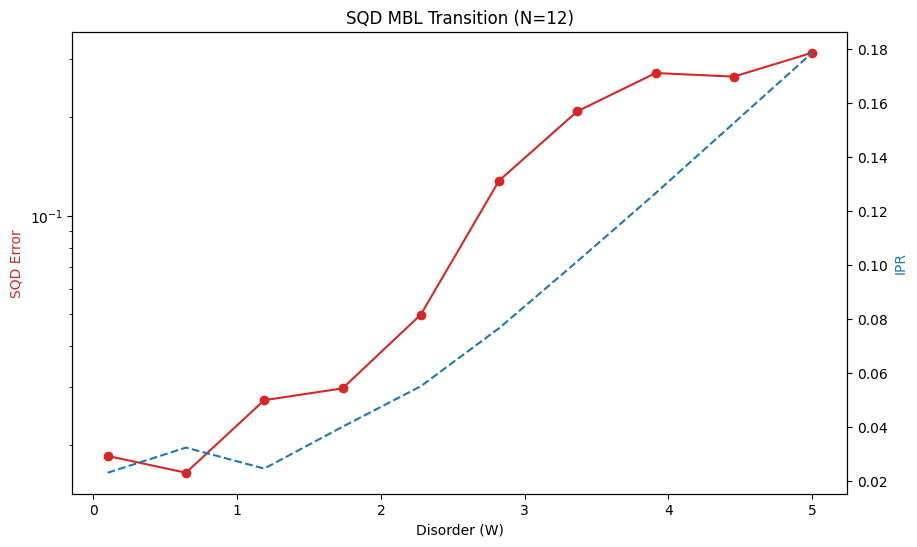

In [ ]:
class MBL_Solver_Robust:
    def __init__(self, N, J, g, W, seed=None):
        self.N = N
        self.J = J
        self.g = g
        self.W = W
        self.rng = np.random.default_rng(seed)
        self.h_z = self.rng.uniform(-self.W, self.W, size=N)

    def get_exact_ground_state(self):
        dim = 2**self.N
        indices = np.arange(dim)
        energy_diag = np.zeros(dim)

        # Diagonal: Ising (ZZ) + Disorder (Z)
        for k in range(self.N):
            bit_k = (indices >> k) & 1
            spin_k = 1 - 2*bit_k
            energy_diag += -self.h_z[k] * spin_k
            if k < self.N - 1:
                bit_kplus1 = (indices >> (k+1)) & 1
                spin_kplus1 = 1 - 2*bit_kplus1
                energy_diag += -self.J * spin_k * spin_kplus1

        H = sp.diags(energy_diag, 0, shape=(dim, dim), format='lil')

        # Off-Diagonal: Uniform Transverse Field (X)
        if abs(self.g) > 1e-10:
            for i in range(dim):
                for k in range(self.N):
                    j = i ^ (1 << k)
                    H[i, j] = -self.g

        eigvals, eigvecs = spla.eigsh(H.tocsr(), k=1, which='SA')
        psi = eigvecs[:, 0]
        ipr = np.sum(np.abs(psi)**4)
        return eigvals[0], ipr

    def _robust_flatten(self, s):
        """ robustly flatten nested lists/tuples/strings to integer list """
        flat = []
        if isinstance(s, str):
            # Handle string '0101...' case
            return [int(c) for c in s]

        if not isinstance(s, Iterable):
            return [s]

        for item in s:
            if isinstance(item, (str, bytes)):
                flat.append(int(item))
            elif isinstance(item, Iterable):
                flat.extend(self._robust_flatten(item))
            else:
                flat.append(item)
        return flat

    def run_sqd(self, samples=1000):
        # Ansatz
        psi0 = qtn.MPS_computational_state('0' * self.N)

        # Build Hamiltonian for TEBD
        H_dict = {}
        Z = qu.spin_operator('Z')
        X = qu.spin_operator('X')
        I = qu.spin_operator('I')

        for i in range(self.N - 1):
            term = -self.J * (Z & Z)
            term += -self.g * (X & I)
            term += -self.h_z[i] * (Z & I)
            if i == self.N - 2:
                term += -self.g * (I & X)
                term += -self.h_z[self.N-1] * (I & Z)
            H_dict[(i, i+1)] = term

        H_local = qtn.LocalHam1D(self.N, H_dict)

        # TEBD
        tebd = qtn.TEBD(psi0, H_local)
        tebd.split_opts['cutoff'] = 1e-12
        tebd.split_opts['max_bond'] = 12
        tebd.update_to(2.0, dt=0.1)

        # Sample
        psi_cpu = tebd.pt.copy()
        psi_cpu.apply_to_arrays(lambda x: x.get() if hasattr(x, 'get') else x)
        raw_samples = list(psi_cpu.sample(samples))

        # Filter & Augment
        unique = set()
        for i, s in enumerate(raw_samples):
            flat = self._robust_flatten(s)

            # Truncate if too long
            if len(flat) > self.N:
                flat = flat[:self.N]

            if len(flat) == self.N:
                unique.add(tuple(flat))
            elif i == 0:
                # DEBUG: Print first failure to help diagnose
                print(f"DEBUG: Dropped sample 0. Len={len(flat)}, Expected={self.N}. Content={flat}")

        # Augmentation (1-flip)
        basis = set(unique)
        for s in unique:
            sl = list(s)
            for k in range(self.N):
                sl[k] = 1 - int(sl[k])
                basis.add(tuple(sl))
                sl[k] = 1 - int(sl[k])

        sorted_basis = sorted(list(basis))
        basis_map = {s: i for i, s in enumerate(sorted_basis)}
        dim_sub = len(sorted_basis)

        # safety check
        if dim_sub == 0:
            print("WARNING: Sampling returned 0 valid states. Returning Classical Energy.")
            # Calculate energy of all-zero state (spin +1)
            e_classical = 0.0
            spins = np.ones(self.N) # All Up (+1)
            e_classical += -self.J * (self.N - 1)
            e_classical += np.sum(-self.h_z * spins)
            return e_classical

        # Build H_sub
        H_sub = sp.lil_matrix((dim_sub, dim_sub))
        for i, s in enumerate(sorted_basis):
            # Diagonal
            spins = np.array([1 if int(x)==0 else -1 for x in s])
            e_diag = -self.J * np.sum(spins[:-1] * spins[1:])
            e_diag += np.sum(-self.h_z * spins)
            H_sub[i, i] = e_diag

            # Off-Diagonal
            sl = list(s)
            for k in range(self.N):
                sl[k] = 1 - int(sl[k])
                t = tuple(sl)
                if t in basis_map:
                    j = basis_map[t]
                    H_sub[i, j] = -self.g
                sl[k] = 1 - int(sl[k])

        # Diagonalize
        # Use dense solver if small, sparse if large
        if dim_sub < 5:
            vals = np.linalg.eigvalsh(H_sub.toarray())
        else:
            vals, _ = spla.eigsh(H_sub, k=1, which='SA')

        return vals[0]

# execution
N = 12
J = 1.0
g = 1.0
W_values = np.linspace(0.1, 5.0, 10)
SAMPLES = 500

errors = []
iprs = []

print(f"Starting Robust MBL Sweep (N={N})...")
for W in W_values:
    sub_errors = []
    sub_iprs = []
    for seed in [10, 11, 12]:
        solver = MBL_Solver_Robust(N, J, g, W, seed=seed)
        try:
            E_ex, ipr = solver.get_exact_ground_state()
            E_sqd = solver.run_sqd(samples=SAMPLES)

            rel_err = abs(E_sqd - E_ex) / abs(E_ex)
            sub_errors.append(rel_err)
            sub_iprs.append(ipr)
        except Exception as e:
            print(f"  CRITICAL FAILURE at W={W}, seed={seed}: {e}")
            continue

    if sub_errors:
        avg_err = np.mean(sub_errors)
        avg_ipr = np.mean(sub_iprs)
        errors.append(avg_err)
        iprs.append(avg_ipr)
        print(f"W={W:.1f} | IPR={avg_ipr:.3f} | Error={avg_err:.2e}")
    else:
        errors.append(np.nan)
        iprs.append(np.nan)

# visualization
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:red'
ax1.set_xlabel('Disorder (W)')
ax1.set_ylabel('SQD Error', color=color)
ax1.plot(W_values, errors, color=color, marker='o')
ax1.set_yscale('log')
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('IPR', color=color)
ax2.plot(W_values, iprs, color=color, linestyle='--')
plt.title(f"SQD MBL Transition (N={N})")
plt.show()